In [ ]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('images/1.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image,(512,512))
_, binary_thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(
    image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2
)
_, otsu_thresh = cv2.threshold(
    image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)


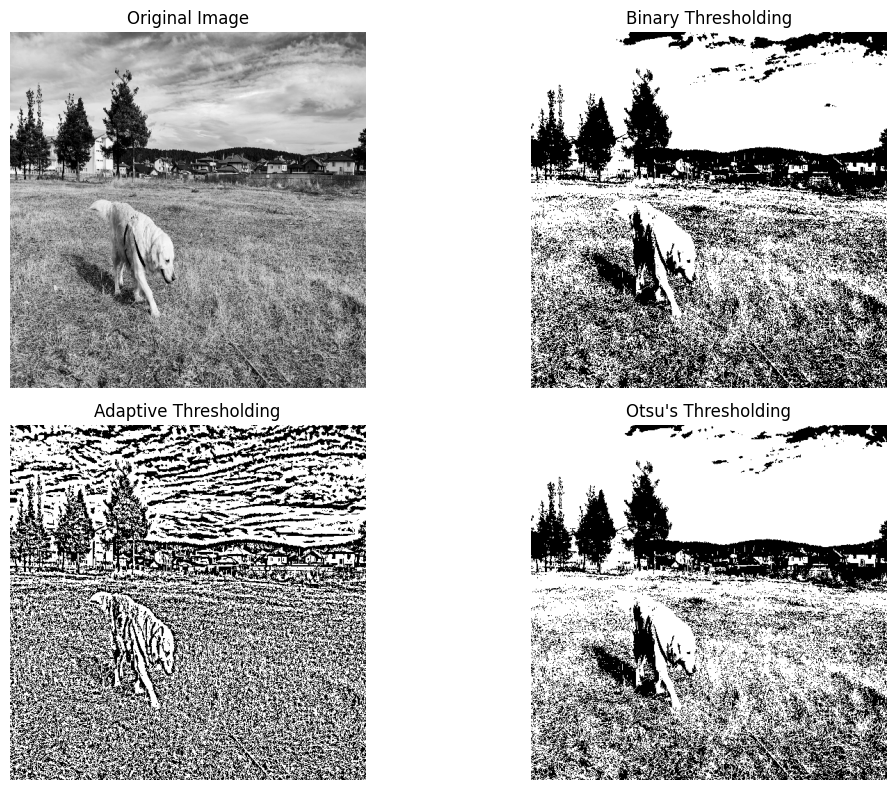

In [ ]:
titles = [
    'Original Image', 'Binary Thresholding', 'Adaptive Thresholding', "Otsu's Thresholding"
]
images = [image, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

Otsu's thresholding worked the best as it automatically finds the threshold based on the image histogram, While adaptive thresholding works good for non-uniform lighting in image (like a photo of a paper) it introduces a lot of noise too in cases of high texture variety (like in our image, it treats each of these variations as localised intensity differences resulting in oversegmentation)
resulting in a very noisy output, binary thresholding does an alright job here since this image doesnt have variation in lighting.

In [ ]:

import numpy as np
def detect_lines(image_path, canny_threshold1, canny_threshold2, hough_threshold):
    image = cv2.imread(image_path)
    image = cv2.resize(image,(512,512))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, canny_threshold1, canny_threshold2)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, hough_threshold)
    if lines is not None:
        for line in lines:
            rho, theta = line[0] #getting the (p,theta) params back from the accumulator space and printing lines with them on top of the image 
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * a)
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * a)
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image, edges

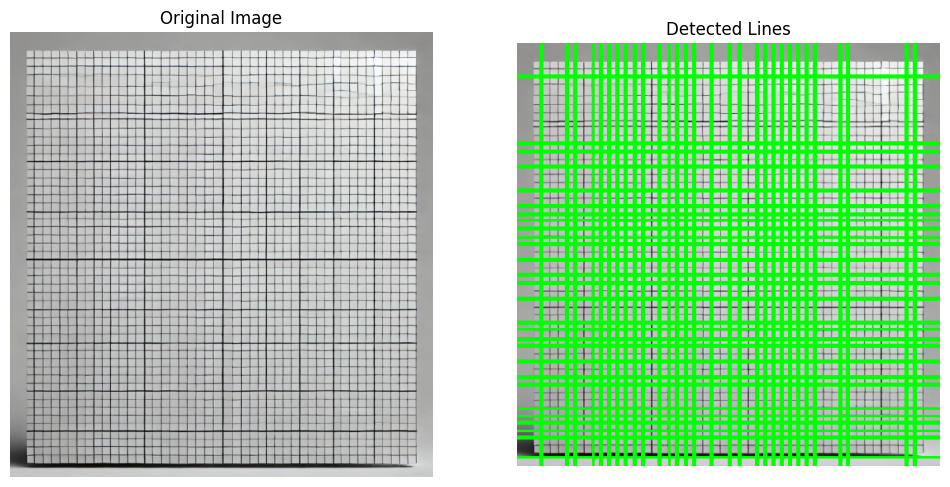

In [ ]:
input_image = 'images/2.png'  
canny_thresh1, canny_thresh2 = 20, 200
hough_thresh = 400
processed_image, edge_image = detect_lines(input_image, canny_thresh1, canny_thresh2, hough_thresh)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(input_image), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines')
plt.axis('off')

plt.show()

detects almost all the lines (except the squigly ones) 

If I increase the hough threshold it detects fewer lines but are more prominent, decreasing it can result in false lines, 

Decreasing the canny detection threshold causes lines to be detected more easily , but can result in more noise in complex images

In [ ]:
def detect_circles(image_path, dp=1.2, min_dist=50, param1=50, param2=30, min_radius=0, max_radius=0):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5) #slight preprocessing for noise reduction
    #Huogh circle transform
    circles = cv2.HoughCircles(
        gray, 
        cv2.HOUGH_GRADIENT, 
        dp, 
        min_dist, 
        param1=param1, 
        param2=param2, 
        minRadius=min_radius, 
        maxRadius=max_radius
    )
    #printing the detected circles on top of the image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  #centre of circle (cx,cy)
            radius = circle[2]  #radius of circle (r)
            cv2.circle(img, center, 2, (0, 255, 0), 3)
            cv2.circle(img, center, radius, (255, 0, 0), 2)
    return img

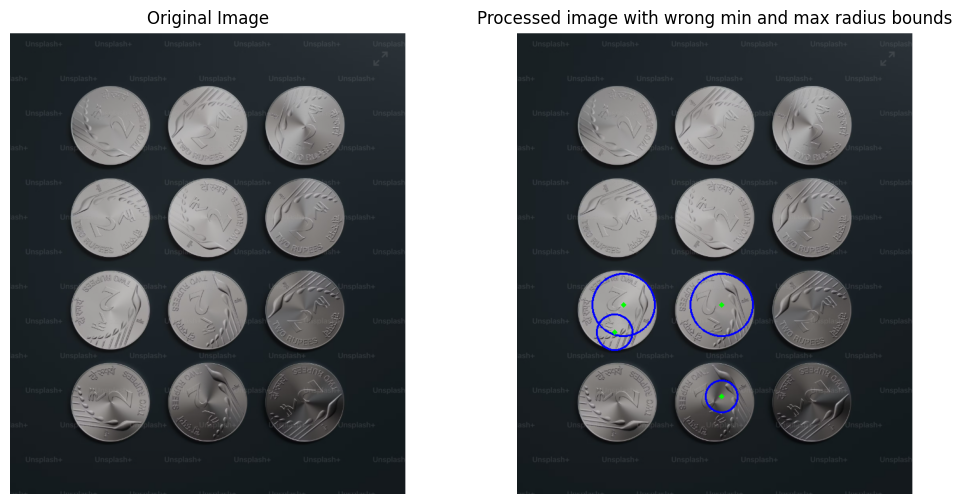

In [37]:
image_path = "images/31.png"  
processed_image = detect_circles(
    image_path, 
    dp=1.2, 
    min_dist=30, 
    param1=100, 
    param2=30, 
    min_radius=10, 
    max_radius=50
)
original = cv2.imread(image_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  
processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title("Processed image with wrong min and max radius bounds")
plt.axis("off")
plt.show()

we have to adjust for the min and max radius accordingly otherwise we will get wrong circles as arguments , so i increased the min radius and the max radius to match those of the coins

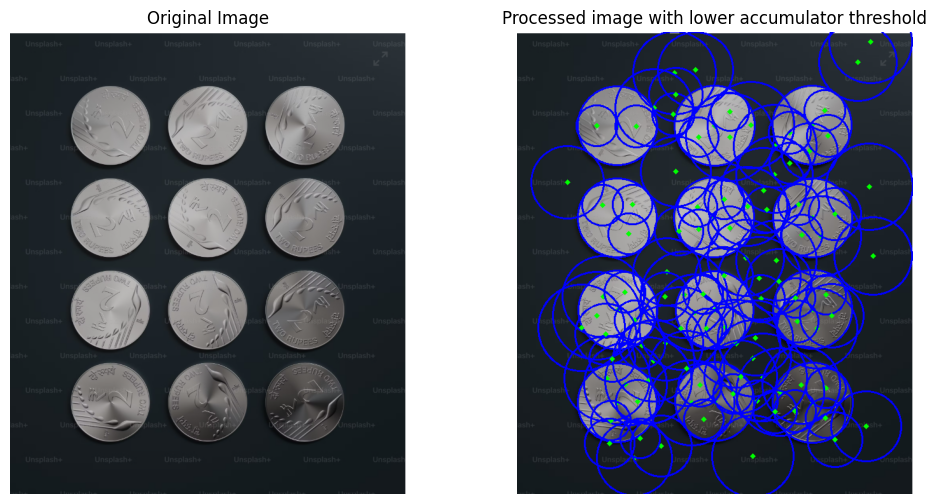

In [35]:
image_path = "images/31.png" 
processed_image = detect_circles(
    image_path, 
    dp=1.2, 
    min_dist=30, 
    param1=100, 
    param2=10, 
    min_radius=30, 
    max_radius=70
)
original = cv2.imread(image_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  
processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title("Processed image with lower accumulator threshold")
plt.axis("off")
plt.show()

lowering the accumulator threshold increases the number of circles but also gives us lots of false positives with bad confidence

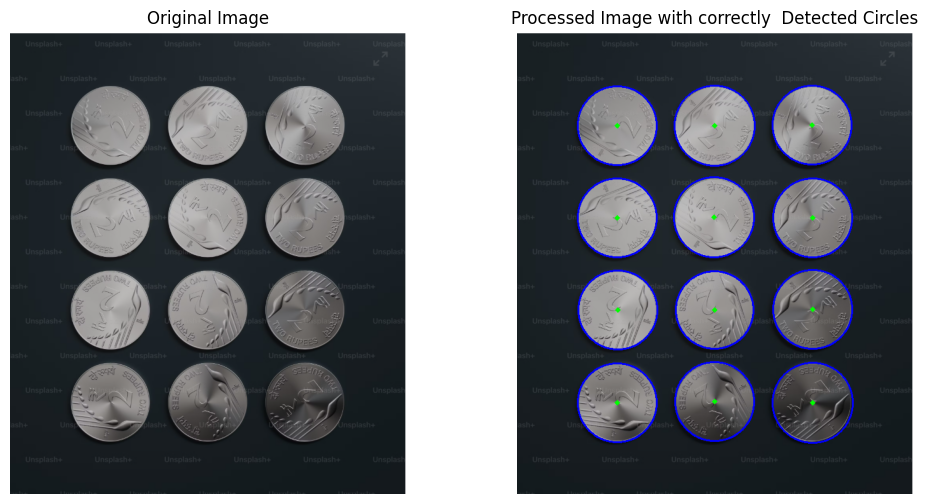

In [ ]:
image_path = "images/31.png"
processed_image = detect_circles(
    image_path, 
    dp=1.2, # ratio of image resolution to accumulator resolution (>1 for faster computation)
    min_dist=30, 
    param1=100, #canny threshold
    param2=30, #this is the accumulator threshold , lowering it lowers the amount of votes needed for circle to be counted as genuine
    min_radius=30, #describing bounds to limit the search space/iteration space
    max_radius=70
)
original = cv2.imread(image_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  
processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(processed_image)
plt.title("Processed Image with correctly  Detected Circles")
plt.axis("off")
plt.show()

found the perfect balance of radius and accumulator threshold to give a perfect circle detection on this image

In [ ]:
def detect_harris_corners(image_path, k=0.04, threshold=0.01, mark_size=5):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=k)
    corners = cv2.dilate(corners, None)
    img_marked = img.copy()

    thresh = threshold * corners.max()
    img_marked[corners > thresh] = [0, 0, 255]#marked as red so they are visible 
    corners_normalized = np.zeros_like(corners)
    cv2.normalize(corners, corners_normalized, 0, 255, cv2.NORM_MINMAX)
    corners_normalized = np.uint8(corners_normalized)
    
    for i in range(corners_normalized.shape[0]):
        for j in range(corners_normalized.shape[1]):
            if corners[i, j] > thresh:
                cv2.circle(img_marked, (j, i), mark_size, (0, 255, 0), 2)
    
    return img, img_marked
def compare_sensitivity(image_path, k_values=[0.02, 0.06, 0.08]): # for the comparision part function
    results = []
    for k in k_values:
        _, marked = detect_harris_corners(image_path, k=k)
        results.append((f'k={k}', marked))
    return results
def display_results(original, marked, title="Harris Corner Detection"):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(marked, cv2.COLOR_BGR2RGB))
    plt.title('Corners Detected')
    plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
def display_sensitivity_comparison(results):
    n_images = len(results)
    plt.figure(figsize=(15, 5))
    for i, (title, img) in enumerate(results, 1):
        plt.subplot(1, n_images, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.suptitle('Comparison of Different k Values')
    plt.tight_layout()
    plt.show()

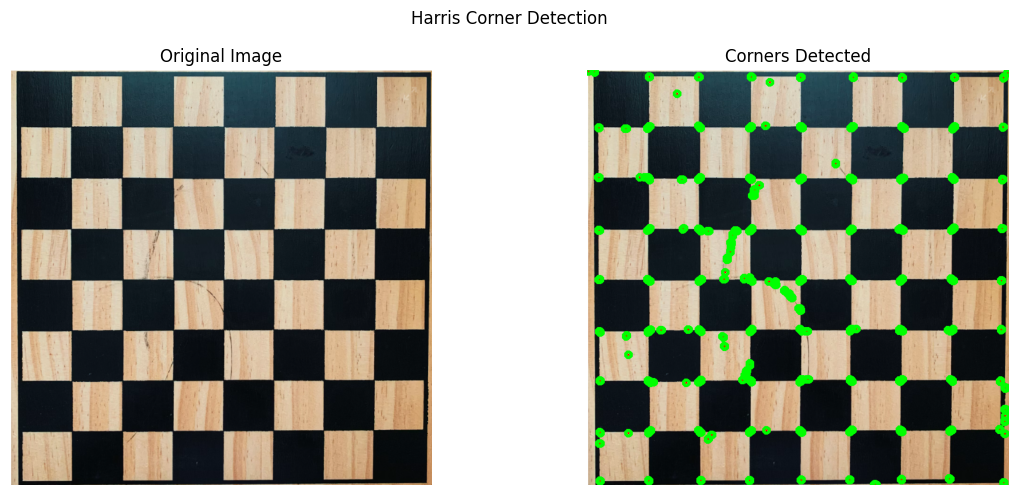

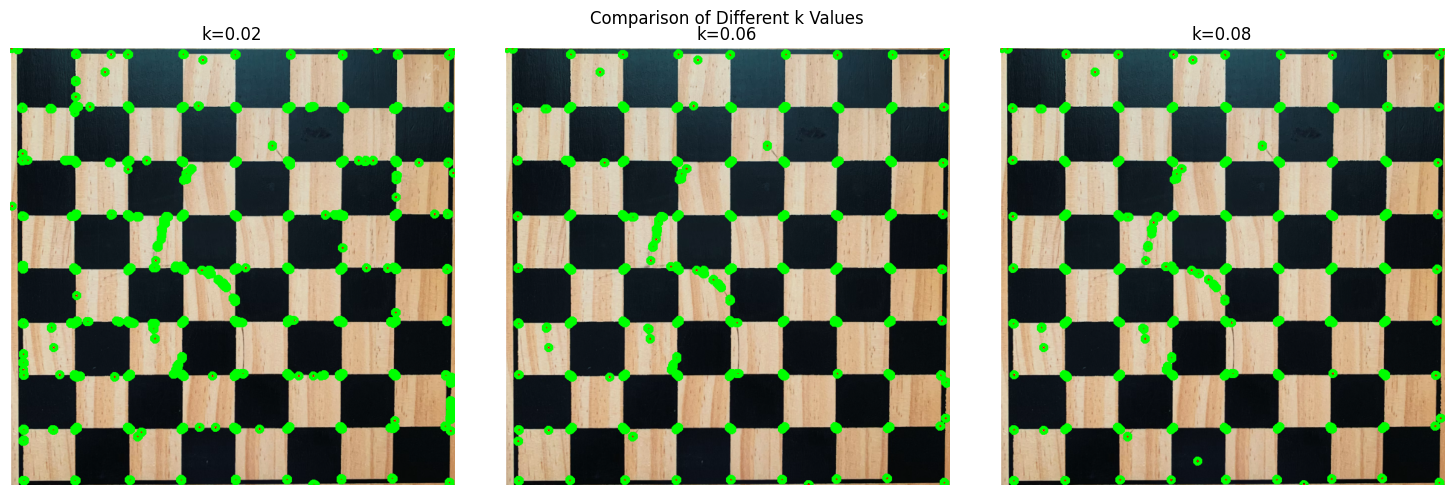

In [ ]:
image_path = "images/44.png"
original, marked = detect_harris_corners(image_path)
display_results(original, marked)
sensitivity_results = compare_sensitivity(image_path)
display_sensitivity_comparison(sensitivity_results)

for a realistic chessboard as the k value goes up it detects less and less corners and the false positive rate goes down , high k- high selectivity, low k - high sensitivity, so a lower k might not be good for realistic scenarios since it results in too many artifacts

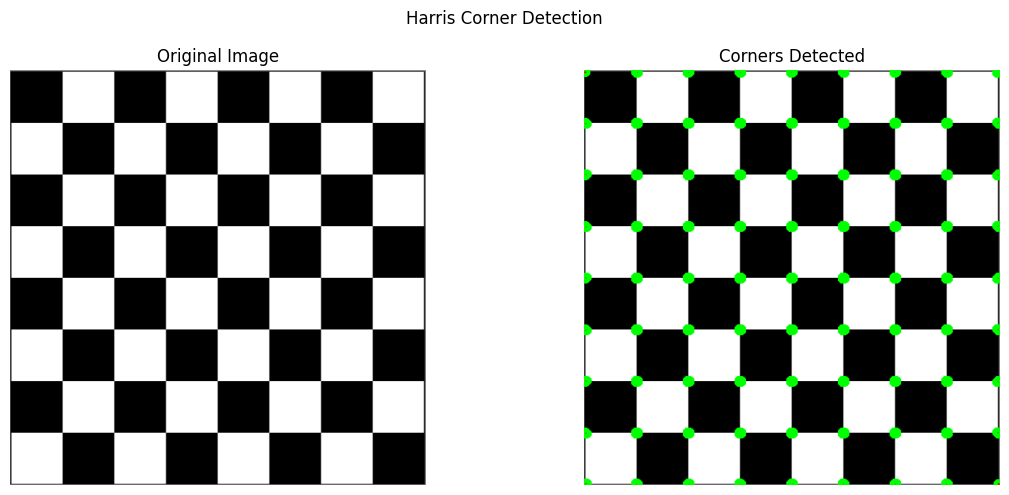

In [ ]:
image_path = "images/41.png"
original, marked = detect_harris_corners(image_path)
display_results(original, marked)

Corner detection done on ideal scenario (artificially generated chessboard pattern)

Question-5


From what I understand , In the line hough transform , we feed a certain number of edge pixels to the function , and the function maps each of these edge points to a parametric space(accumulator space) (p,theta) (p for perpendicular distance from centre , and theta for the angle cast on x axis) depicting the possible lines that can be passing through this specific edge point ,this is done for all the given edge points from the canny map , and then we detect the coincidences/peaks in the accumulator space(voting) , a high amount of peaks on a specific (p,theta) point in the space suggests that this line might actually exist in our image , which is then converted back from the (p,theta) to an actual projected line and displayed on top of the image.                                                                                                          
Time complexity should be of order O(N*k) where N designates the number of edge points being fed , and k depicts the parameters i.e 2 parameters but need to be iterated over the entire range (theta is being iterated over 0 to 180 degrees and p is for being sampled till the bounds of the image for example) for each point
                                                                                                                                                
.
.
In the Hough Circle transform , we Iterate and vote differently, the key difference is that each edge point now is mapped to a 3D space (cx,cy,r)
for each edge point , it iterates over all the possible circles(centre (cx,cy),radius r) that could be passing through this point and maps those circles into this 3-D parameter (accumulator) space ,                                                                                            
This can get computationally expensive so it is done with a lot of bounds in mind (min radius , max radius , distance between radius , accumulator resolution(how many fine iterations per point) etc), then a voting is done at the end inside of this space , and coinciding/peaks in this 3-D space (cx,cy,r) suggest the existence of that circle with centre cx cy and radius r in the original image , which is then shown on top of the original image
.                                                                                                                                                

The time complexity should be O(N*k) again but this time k involves more parameters and way more iterations since it is being done on a higher dimension with more things to iterate over (even with optimisations and bounds it still might take longer).
